This notebook predicts the direction of the S&P 500 Index

# Import

In [2]:
import datetime
import pandas as pd
from matplotlib import pyplot as plt
import yfinance as yf

In [3]:
sp500 = yf.Ticker("^GSPC")
sp500 = sp500.history(period = "max")
sp500.to_csv("/Users/tgut03/Jupyter/Data/SP500 Index.csv")

# Transform

In [4]:
# Convert Data Types
sp500.index = pd.to_datetime(sp500.index, utc = True)
sp500.index = sp500.index.date

In [5]:
# Remove Columns
del sp500["Dividends"]
del sp500["Stock Splits"]

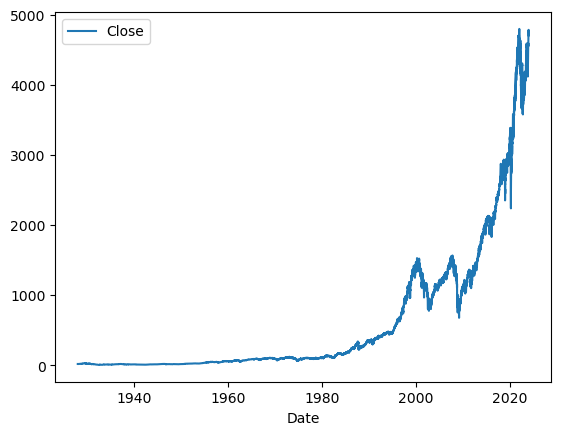

In [6]:
# Plot Close Price
sp500.plot(kind = "line", y = "Close", use_index = True)
plt.xlabel("Date")
plt.show()

In [7]:
# Tomorrow = Close - 1
sp500["Tomorrow"] = sp500["Close"].shift(-1)

# If Up Then 1 Else 0
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)

# Get Date After January 1990
date = datetime.date(1990, 1, 1)
sp500 = sp500[sp500.index >= date].copy()
sp500

,Open,High,Low,Close,Volume,Tomorrow,Target
1990-01-02,353.399994,359.690002,351.980011,359.690002,162070000,358.760010,0
1990-01-03,359.690002,360.589996,357.890015,358.760010,192330000,355.670013,0
1990-01-04,358.760010,358.760010,352.890015,355.670013,177000000,352.200012,0
1990-01-05,355.670013,355.670013,351.350006,352.200012,158530000,353.790009,1
1990-01-08,352.200012,354.239990,350.540009,353.790009,140110000,349.619995,0
...,...,...,...,...,...,...,...
2023-12-27,4773.450195,4785.390137,4768.899902,4781.580078,2748450000,4783.350098,1
2023-12-28,4786.439941,4793.299805,4780.979980,4783.350098,2698860000,4769.830078,0
2023-12-29,4782.879883,4788.430176,4751.990234,4769.830078,3126060000,4742.830078,0
2024-01-02,4745.200195,4754.330078,4722.669922,4742.830078,3743050000,4704.810059,0


# Model

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score

# Split Dataset
train = sp500[:-100]
test = sp500[-100:]

# Select Features
prices = ["Open", "Close", "High", "Low", "Volume"]

# Select Model
model = RandomForestClassifier(n_estimators = 100, min_samples_split = 100, random_state = 1)

# Train Model
model.fit(train[prices], train["Target"])

# Generate Predictions
preds = model.predict(test[prices])

# Store Predictions
preds = pd.Series(preds, index = test.index)

# Evaluate Model
score = precision_score(test["Target"], preds)
print(f"precision = {score.round(2)}")

precision = 0.54


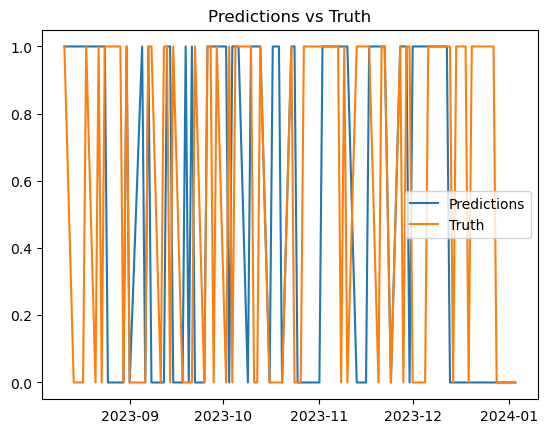

In [9]:
# Store Predictions and Truth
predsTruth = pd.concat([preds, test["Target"]], axis = 1)

# Plot Predictions vs Truth
predsTruth.plot(kind = "line")
plt.title("Predictions vs Truth")
plt.legend(["Predictions", "Truth"])
plt.show()

# Automate

In [10]:
# Predict Function
def predict(train, test, prices, model) :
    model.fit(train[prices], train["Target"]) # Train Model
    preds = model.predict(test[prices]) # Generate Predictions
    preds = pd.Series(preds, index = test.index, name = "Predictions") # Store Predictions
    predsTruth = pd.concat([preds, test["Target"]], axis = 1) # Store Predictions and Truth
    return predsTruth

# Backtest

In [11]:
# Backtest Function
def backtest(data, prices, model, start = 2500, step = 250) : # 1 yr = 250 trading days
    totPreds = [] # Store Predictions
    
    for i in range(start, data.shape[0], step) :
        train = data.iloc[0:i].copy() # Window
        test = data.iloc[i:(i+step)].copy() # Sliding Window
        preds2 = predict(train, test, prices, model) # Predict Function
        totPreds.append(preds2) # Add 2nd Predictions
    return pd.concat(totPreds)

In [12]:
# Generate 2nd Predictions
preds2 = backtest(sp500, prices, model)

# Evaluate Model
score = precision_score(preds2["Target"], preds2["Predictions"])
print(f"precision = {score.round(2)}")

precision = 0.53


# Technicals

In [13]:
# Technical Indicators
horizons = [2, 5, 60, 250, 1000]
teks = []

for horizon in horizons : 
    rollAvgs = sp500.rolling(horizon).mean()
    
    ratio = f"{horizon} Day Close Ratio"
    sp500[ratio] = sp500["Close"] / rollAvgs["Close"]
    
    trend = f"{horizon} Day Trend"
    sp500[trend] = sp500.shift(1).rolling(horizon).sum()["Target"]
    
    teks += [ratio, trend]

# Remove Nulls
sp500 = sp500.dropna()
sp500

,Open,High,Low,Close,Volume,Tomorrow,Target,2 Day Close Ratio,2 Day Trend,5 Day Close Ratio,5 Day Trend,60 Day Close Ratio,60 Day Trend,250 Day Close Ratio,250 Day Trend,1000 Day Close Ratio,1000 Day Trend
1993-12-14,465.730011,466.119995,462.459991,463.059998,275050000,461.839996,0,0.997157,1.0,0.996617,1.0,1.000283,32.0,1.028047,127.0,1.176082,512.0
1993-12-15,463.059998,463.690002,461.839996,461.839996,331770000,463.339996,1,0.998681,0.0,0.995899,1.0,0.997329,32.0,1.025151,126.0,1.172676,512.0
1993-12-16,461.859985,463.980011,461.859985,463.339996,284620000,466.380005,1,1.001621,1.0,0.999495,2.0,1.000311,32.0,1.028274,127.0,1.176163,513.0
1993-12-17,463.339996,466.380005,463.339996,466.380005,363750000,465.850006,0,1.003270,2.0,1.004991,3.0,1.006561,32.0,1.034781,128.0,1.183537,514.0
1993-12-20,466.380005,466.899994,465.529999,465.850006,255900000,465.299988,0,0.999431,1.0,1.003784,2.0,1.005120,32.0,1.033359,128.0,1.181856,513.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-26,4758.859863,4784.720215,4758.450195,4774.750000,2513910000,4781.580078,1,1.002111,2.0,1.005513,4.0,1.073161,38.0,1.117612,136.0,1.203740,529.0
2023-12-27,4773.450195,4785.390137,4768.899902,4781.580078,2748450000,4783.350098,1,1.000715,2.0,1.006392,4.0,1.072714,38.0,1.118166,137.0,1.204993,530.0
2023-12-28,4786.439941,4793.299805,4780.979980,4783.350098,2698860000,4769.830078,0,1.000185,2.0,1.003175,5.0,1.070893,39.0,1.117603,137.0,1.204974,530.0
2023-12-29,4782.879883,4788.430176,4751.990234,4769.830078,3126060000,4742.830078,0,0.998585,1.0,0.999372,4.0,1.065854,38.0,1.113476,137.0,1.201116,529.0


# Probability

In [14]:
# Model
model = RandomForestClassifier(n_estimators = 200, min_samples_split = 50, random_state = 1)

# Predict Probability Function
def predictProba(train, test, prices, model) :
    model.fit(train[prices], train["Target"]) # Train Model
    preds = model.predict_proba(test[prices])[:,1] # Extract Predictions Probability
    preds[preds >= 0.6] = 1 # Up Probability Threshold
    preds[preds < 0.6] = 0 # Down Probability Threshold
    preds = pd.Series(preds, index = test.index, name = "Predictions") # Store Predictions
    predsTruth = pd.concat([preds, test["Target"]], axis = 1) # Store Predictions and Truth
    return predsTruth

In [15]:
# Generate 3rd Predictions
preds2 = backtest(sp500, teks, model)
preds2["Predictions"].value_counts()

# Evaluate Model
score = precision_score(preds2["Target"], preds2["Predictions"])
print(f"precision = {score.round(2)}")

# Truth
truth = (preds2["Target"].value_counts() / preds2["Predictions"].shape[0]).round(2)
positiveTruth = truth[1]
print(f"truth 1s = {positiveTruth}")

precision = 0.55
truth 1s = 0.54


# Results
My model correctly predicted the S&P 500 Index would go up 55% of the days while the S&P 500 Index went up 54% of the days